<a href="https://colab.research.google.com/github/ByeongKyuPark/ByeongKyuPark.github.io/blob/main/CS445_Proj2_Starter_(1)_grok3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Programming Project #2: Image Quilting

## CS445: Computational Photography


In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import time

datadir = "/content/drive/MyDrive/Colab Notebooks/CS445 Computational Photography/2_Project_Image_Quilting/"

utilfn = datadir + "utils.py"
!cp "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .
import utils

In [50]:
from utils import cut # default cut function for seam finding section

### Utils

In [90]:
def random_patch(sample, patch_size):
    # extract a random patch from sample of size patch_size x patch_size.
    H, W, C = sample.shape
    i = random.randint(0, H - patch_size)
    j = random.randint(0, W - patch_size)
    return sample[i:i+patch_size, j:j+patch_size]

def ssd_patch(sample, template, mask):
    # SSD between template (from the output) <-> all possible patches in the sample(e.g., texture)
    # SSD = ∑ [ (T•M-S•M) **2] = ∑[ ((T-S)•M) **2] = ∑ (T^2-2TS+S^2)•M
		# 										 = ∑ M•T^2 -2∑(M•T)S + ∑(M•S^2)
		# 										 # M=M^2 for binary M(either 0 or 1)
		# 										 = ∑ (M•T)^2 -2∑(M•T)S + ∑(M•S^2)
		# => ((M*T)**2).sum() - 2*cv2.filter2D(S,kernel = M*T) + cv2.filter2D(S ** 2, kernel=M).

    # for precisions
    template = template.astype(np.float32) # e.g., (3x3)
    sample = sample.astype(np.float32)     # e.g., (5x5)
    mask = mask.astype(np.float32)         # e.g., (3x3)

    s_h, s_w = sample.shape[0], sample.shape[1]
    t_h, t_w = template.shape[0], template.shape[1]

    kernel_h = s_h - t_h + 1 # 5-3+1 = 3
    kernel_w = s_w - t_w + 1 # 5-3+1 = 3

    # 3x3
    ssd_cost = np.zeros((kernel_h, kernel_w), dtype=np.float32)

    # see the comments below
    padding_h, padding_w = (t_h - 1) // 2, (t_w - 1) // 2

    for channel in range(sample.shape[2]):
        M = mask
        T = template[:, :, channel]
        S = sample[:, :, channel]

        # 'cv2.filter2D' internally adds padding for edge computations
        # e.g., for sample[0,0], it pads to include kernel data outside 5x5
        filtered_S = cv2.filter2D(S, -1, M * T)
        filtered_S2 = cv2.filter2D(S ** 2, -1, M)

        # therefore, we trim padded edges to get valid 3x3 cost
        valid_filtered_S = filtered_S[padding_h:padding_h + kernel_h, padding_w:padding_w + kernel_w]
        valid_filtered_S2 = filtered_S2[padding_h:padding_h + kernel_h, padding_w:padding_w + kernel_w]

        ssd_cost += ((M * T) ** 2).sum() - 2 * valid_filtered_S + valid_filtered_S2

    return ssd_cost

def choose_sample(ssd_cost, tol):
    # flatten the cost array
    cols = ssd_cost.shape[1]
    ssd_cost = ssd_cost.flatten()

    # get indices of ascending orders
    sorted_indices = np.argsort(ssd_cost)

    # select one randomly from the top 'tol' cheapest candidates
    selected_index = sorted_indices[random.randint(0, min(tol - 1, len(sorted_indices) - 1))]

    # to 2D again
    return  selected_index // cols , selected_index % cols

### Part I: Randomly Sampled Texture (10 pts)

In [52]:
def quilt_random(sample, out_size, patch_size): # (192,192,3), 200, 15
    """
    I. Naive Random Patch Quilting
        Randomly picks patches from the sample texture and places them into the output image.
    """
    H, W, C = sample.shape # 192, 192, 3
    print(f'sample size = {H}, {W}, {C}')
    num_patches = int(np.ceil(out_size / patch_size)) # 200/15 = 13.~ -> 14
    print(f'{num_patches} patches') # 14 patches

    # an imaginary canvas for the output (slightly bigger than the output)
    out_canvas_width = num_patches * patch_size # 210
    print(f'{out_canvas_width} output canvas size') # larger than out_size
    out_canvas = np.zeros((out_canvas_width, out_canvas_width, C), dtype=sample.dtype) # 210 X 210

    for i in range(num_patches):
        for j in range(num_patches):
            patch = random_patch(sample, patch_size)
            out_canvas[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = patch

    # crop the output image to exactly out_size x out_size.
    print(f'output canvas (before clamping) : {out_canvas.shape}') # larger than out_size
    # clamp the canvas to fit into the out size
    return out_canvas[:out_size, :out_size, :]


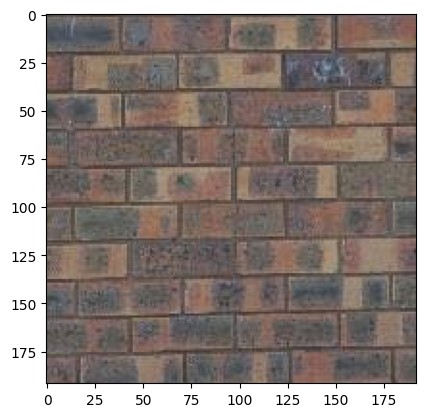

sample size = 192, 192, 3
5 patches
225 output canvas size
output canvas (before clamping) : (225, 225, 3)


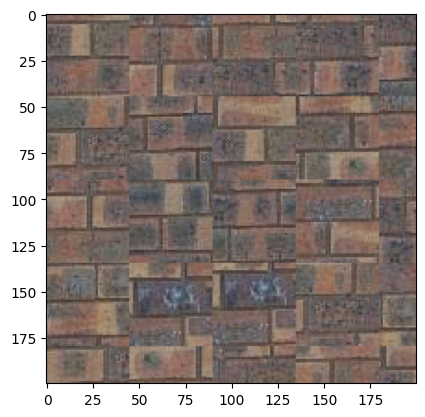

In [53]:
sample_img_fn = 'samples/bricks_small.jpg' # feel free to change
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 200  # change these parameters as needed
patch_size = 45
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.imshow(res)

### Part II: Overlapping Patches (30 pts)

In [69]:
def quilt_simple(sample, out_size, patch_size, overlap, tol):
    # better precision
    sample = np.array(sample, dtype=np.float32)

    # e.g., 200x200x3 zeros for toast output
    result = np.zeros((out_size, out_size, sample.shape[2]), dtype=np.float32)

    # e.g., 70 - 25 = 45 stride for 70x70 patches, 25 overlap
    stride = patch_size - overlap

    # number of patches to cover the output
    # e.g., ((200 - 1) // 45) + 1 = 5 patches each way for 200 output
    patches_x = ((out_size - 1) // stride) + 1
    patches_y = ((out_size - 1) // stride) + 1

    for i in range(patches_y):
        for j in range(patches_x):

            # clamp to boundaries
            # e.g., min(0 * 45, 200 - 70) = 0, min(4 * 45, 200 - 70) = 130
            start_y = min(i * stride, out_size - patch_size)
            start_x = min(j * stride, out_size - patch_size)

            # for the first patch, grab a random chunk
            if i == 0 and j == 0:
                patch = random_patch(sample, patch_size)
                result[start_y:start_y + patch_size, start_x:start_x + patch_size] = patch
            else:
                # boolean for overlaps checks (left or top)
                left_overlap = j > 0
                top_overlap = i > 0

                # mask for overlap zones (1s where patches touch)
                # e.g., 3x3 mask with 1s in left 1 column for 1 overlap
                mask = np.zeros((patch_size, patch_size), dtype=np.float32)
                if left_overlap:
                    mask[:, :overlap] = 1  # left 25 pixels for toast match
                if top_overlap:
                    mask[:overlap, :] = 1  # top 25 pixels for toast match

                # grab the current output patch (overlap area only)
                # e.g., 3x3 patch from 5x5 output, mask 1s in overlap
                temp = result[start_y:start_y + patch_size, start_x:start_x + patch_size].copy()
                temp *= mask[..., np.newaxis]

                # find a best patch match (using SSD)
                cost_map = ssd_patch(sample, temp, mask)
                patch_y, patch_x = choose_sample(cost_map, int(tol))
                patch = sample[patch_y:patch_y + patch_size, patch_x:patch_x + patch_size]

                # e.g., place 3x3 patch at (0,2) in 5x5 output with 1 overlap
                result[start_y:start_y + patch_size, start_x:start_x + patch_size] = patch

    # e.g., clip 200x200 toast to unsigned char (0–255) values
    return np.clip(result, 0, 255).astype(np.uint8)

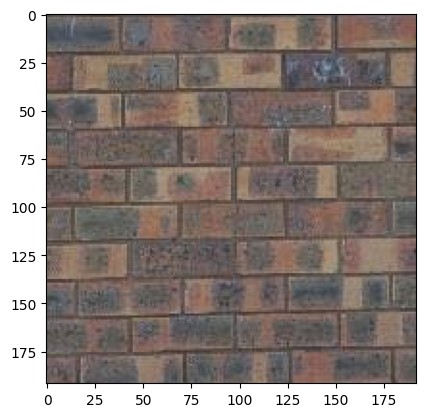

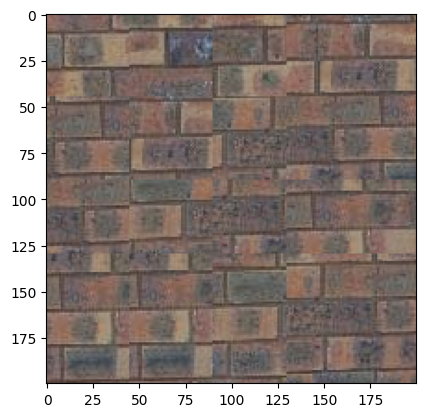

In [70]:
sample_img_fn = 'samples/bricks_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 200  #300 change these parameters as needed (was 300)
patch_size = 70 # 25
overlap = 25 # 11
tol = 15
res = quilt_simple(sample_img, out_size, patch_size, overlap, tol) #feel free to change parameters to get best results
if res is not None:
    # plt.figure(figsize=(10,10))
    plt.imshow(res)

### Part III: Seam Finding (20 pts)


In [71]:
def quilt_cut(sample, out_size, patch_size, overlap, tol):
    # floats for btter precisions
    sample = np.array(sample, dtype=np.float32)

    result = np.zeros((out_size, out_size, sample.shape[2]), dtype=np.float32)

    stride = patch_size - overlap

    # count patches to cover the whole output
    # e.g., ((200 - 1) // 39) + 1 = 6 patches each way for 200 output
    patches_x = ((out_size - 1) // stride) + 1  # full width coverage
    patches_y = ((out_size - 1) // stride) + 1  # full height coverage

    for i in range(patches_y):
        for j in range(patches_x):

            # clamp to boundaries
            # e.g., min(0 * 39, 200 - 50) = 0, min(5 * 39, 200 - 50) = 145
            start_y = min(i * stride, out_size - patch_size)  # fit vertically
            start_x = min(j * stride, out_size - patch_size)  # fit horizontally

            if i == 0 and j == 0:
                # rando for the very first one
                patch = random_patch(sample, patch_size)
                result[start_y:start_y + patch_size, start_x:start_x + patch_size] = patch
            else:
                # checking overlaps
                left_edge = j > 0
                top_edge = i > 0

                # mask for overlap regions
                mask = np.zeros((patch_size, patch_size), dtype=np.float32)
                if left_edge:
                    mask[:, :overlap] = 1
                if top_edge:
                    mask[:overlap, :] = 1

                # grab current output patch (overlap area only)
                temp = result[start_y:start_y + patch_size, start_x:start_x + patch_size].copy()
                temp *= mask[..., np.newaxis]

                # find best patch match using SSD
                cost_map = ssd_patch(sample, temp, mask)
                patch_y, patch_x = choose_sample(cost_map, int(tol))
                patch = sample[patch_y:patch_y + patch_size, patch_x:patch_x + patch_size]

                # set up mask for seam cutting (1 means new patch)
                full_mask = np.ones((patch_size, patch_size), dtype=bool)

                # cut left overlap if exists
                if left_edge:
                    old_left = result[start_y:start_y + patch_size, start_x:start_x + overlap]
                    new_left = patch[:, :overlap]
                    diff_left = np.sum((old_left - new_left) ** 2, axis=2)
                    left_seam = cut(diff_left.T).T  # flip (for vertical cut - utils.py) then and flips it back.
                    full_mask[:, :overlap] = left_seam

                # cut top overlap if exists
                if top_edge:
                    old_top = result[start_y:start_y + overlap, start_x:start_x + patch_size]
                    new_top = patch[:overlap, :]
                    diff_top = np.sum((old_top - new_top) ** 2, axis=2)
                    top_seam = cut(diff_top)
                    full_mask[:overlap, :] = top_seam

                # cut corner overlap (both left and top) if exists
                if left_edge and top_edge:
                    corner_left = left_seam[:overlap, :overlap]
                    corner_top = top_seam[:overlap, :overlap]
                    full_mask[:overlap, :overlap] = np.logical_and(corner_left, corner_top)

                # blend patch into output using seam mask
                out_patch = result[start_y:start_y + patch_size, start_x:start_x + patch_size]
                result[start_y:start_y + patch_size, start_x:start_x + patch_size] = np.where(
                    full_mask[..., np.newaxis], patch, out_patch)

    # clamp to the output
    return np.clip(result, 0, 255).astype(np.uint8)

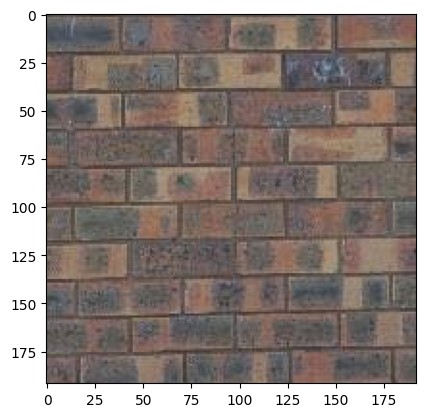

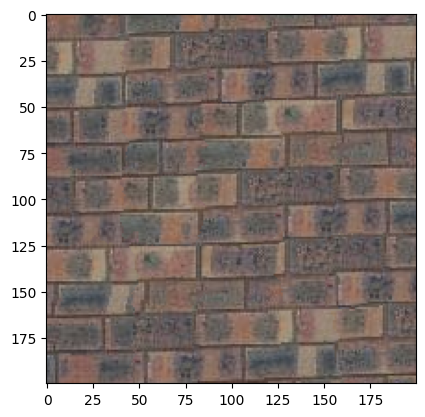

In [72]:
sample_img_fn = 'samples/bricks_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 200  # 300, change these parameters as needed
patch_size = 50 # 25
overlap = 11    # 11
tol = 3
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    #plt.figure(figsize=(15,15))
    plt.imshow(res)

### part IV: Texture Transfer (30 pts)

In [91]:
def texture_transfer(sample, patch_size, overlap, tol, guide_img, alpha):
    # Texture transfer using seam-finding with the provided cut function.

    sample = np.array(sample, dtype=np.float32)
    guide_img = np.array(guide_img, dtype=np.float32)

    out_height, out_width = guide_img.shape[:2]
    result = np.zeros((out_height, out_width, sample.shape[2]), dtype=np.float32)

    stride = patch_size - overlap

    # number of patches needed to cover the face (guidance image)
    # e.g., ((300 - 12) // 9) + 1 = 34 patches each way for 300 output
    patches_y = ((out_height - patch_size) // stride) + 1
    patches_x = ((out_width - patch_size) // stride) + 1

    for i in range(patches_y):
        for j in range(patches_x):
            # e.g., min(0 * 9, 300 - 12) = 0, min(33 * 9, 300 - 12) = 288
            start_y = min(i * stride, out_height - patch_size)
            start_x = min(j * stride, out_width - patch_size)

            if i == 0 and j == 0:
                patch = random_patch(sample, patch_size)
                result[start_y:start_y + patch_size, start_x:start_x + patch_size] = patch
            else:
                left_edge = j > 0
                top_edge = i > 0

                overlap_mask = np.zeros((patch_size, patch_size), dtype=np.float32)
                if left_edge:
                    overlap_mask[:, :overlap] = 1
                if top_edge:
                    overlap_mask[:overlap, :] = 1

                # grab current output patch (overlap area only)
                temp = result[start_y:start_y + patch_size, start_x:start_x + patch_size].copy()
                temp *= overlap_mask[..., np.newaxis]

                # 1. compute SSD for "toast" overlap match
                overlap_cost = ssd_patch(sample, temp, overlap_mask)

                # 2. compute SSD for "face" guide match
                #   grab face guide patch for shape match
                guide_patch = guide_img[start_y:start_y + patch_size, start_x:start_x + patch_size]
                #   mask for full guide match (all 1s)
                guide_mask = np.ones((patch_size, patch_size), dtype=np.float32)
                guide_cost = ssd_patch(sample, guide_patch, guide_mask)

                # 3. consider both costs
                total_cost = (1 - alpha) * overlap_cost + alpha * guide_cost

                # pick one patch amont top N
                patch_y, patch_x = choose_sample(total_cost, int(tol))
                patch = sample[patch_y:patch_y + patch_size, patch_x:patch_x + patch_size]

                # mask for seam cutting
                full_mask = np.ones((patch_size, patch_size), dtype=bool)

                if left_edge:
                    old_left = result[start_y:start_y + patch_size, start_x:start_x + overlap]
                    new_left = patch[:, :overlap]
                    diff_left = np.sum((old_left - new_left) ** 2, axis=2)
                    left_seam = cut(diff_left.T).T
                    full_mask[:, :overlap] = left_seam

                if top_edge:
                    old_top = result[start_y:start_y + overlap, start_x:start_x + patch_size]
                    new_top = patch[:overlap, :]
                    diff_top = np.sum((old_top - new_top) ** 2, axis=2)
                    top_seam = cut(diff_top)
                    full_mask[:overlap, :] = top_seam

                # for both cuts
                if left_edge and top_edge:
                    corner_left = left_seam[:overlap, :overlap]
                    corner_top = top_seam[:overlap, :overlap]
                    full_mask[:overlap, :overlap] = np.logical_and(corner_left, corner_top)

                # blend patch into output using 'seam mask'
                out_patch = result[start_y:start_y + patch_size, start_x:start_x + patch_size]
                result[start_y:start_y + patch_size, start_x:start_x + patch_size] = np.where(
                    full_mask[..., np.newaxis], patch, out_patch)

    # clamps
    return np.clip(result, 0, 255).astype(np.uint8)

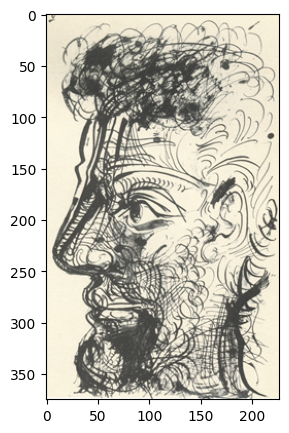

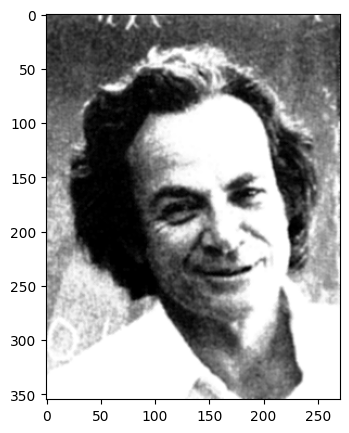

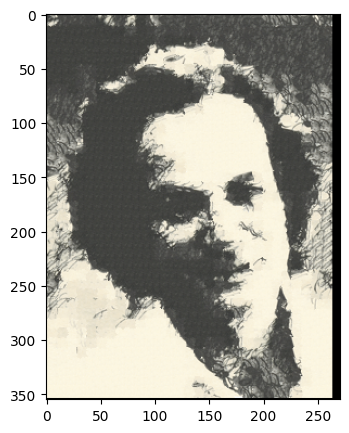

In [92]:
texture_img = cv2.cvtColor(cv2.imread('samples/sketch.tiff'), cv2.COLOR_BGR2RGB)
#texture_img = cv2.cvtColor(cv2.imread('samples/bricks_small.jpg'), cv2.COLOR_BGR2RGB)
#guidance_img = cv2.cvtColor(cv2.imread('samples/feynman.tiff'), cv2.COLOR_BGR2RGB)
guidance_img = cv2.cvtColor(cv2.imread('samples/feynman.tiff'), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5,5))
plt.imshow(texture_img)
plt.show()
plt.figure(figsize=(5,5))
plt.imshow(guidance_img)
plt.show()

# load/process appropriate input texture and guidance images

patch_size =12
overlap = 3
tol = 3
alpha = 0.5
res = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)

plt.figure(figsize=(5,5))
plt.imshow(res)
plt.show()

### Bells & Whistles

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

In [81]:
def iterative_texture_transfer(sample, patch_size, overlap, tol, guidance_im, alpha, num_iters):
    """
    Chill texture loop: refines toast-face blend over multiple rounds for smoothness.
    Uses random starts, SSD picks, and seam cuts, no rough edges.
    """
    # first round is the same basic texture transfering
    result = texture_transfer(sample, patch_size, overlap, tol, guidance_im, alpha)

    # gonna refine over and over
    for _ in range(1, num_iters):
        sample = np.array(sample, dtype=np.float32)
        guidance_im = np.array(guidance_im, dtype=np.float32)

        out_height, out_width = guidance_im.shape[:2]

        stride = patch_size - overlap

        # number of patches required to cover the face
        patches_y = ((out_height - patch_size) // stride) + 1
        patches_x = ((out_width - patch_size) // stride) + 1

        for i in range(patches_y):
            for j in range(patches_x):
                # clamp to boundaires
                start_i = min(i * stride, out_height - patch_size)
                start_j = min(j * stride, out_width - patch_size)

                # check overlaps
                left_overlap = j > 0
                top_overlap = i > 0

                # mask for overlap areas
                mask = np.zeros((patch_size, patch_size), dtype=np.float32)
                if left_overlap:
                    mask[:, :overlap] = 1
                if top_overlap:
                    mask[:overlap, :] = 1

                # grab current patch for overlap
                template = result[start_i:start_i + patch_size, start_j:start_j + patch_size].copy().astype(np.float32)
                template *= mask[..., np.newaxis]

                # 1. SSD for the 'toast'
                overlap_ssd = ssd_patch(sample, template, mask)

                # 2. SSD for the 'face'
                #   grab face guide patch
                guide_patch = guidance_im[start_i:start_i + patch_size, start_j:start_j + patch_size]
                #   mask for full guide match
                guide_mask = np.ones((patch_size, patch_size), dtype=np.float32)
                guidance_ssd = ssd_patch(sample, guide_patch, guide_mask)

                # 3. mix costs
                total_cost = (1 - alpha) * overlap_ssd + alpha * guidance_ssd

                # try picking patch with low cost, skip if fails
                try:
                    patch_y, patch_x = choose_sample(total_cost, tol)
                except ValueError as e:
                    print(f"patch pick failed: {e}")
                    continue
                patch = sample[patch_y:patch_y + patch_size, patch_x:patch_x + patch_size]

                # set up mask for seam cuts
                full_mask = np.ones((patch_size, patch_size), dtype=bool)

                if left_overlap:
                    old_left = result[start_i:start_i + patch_size, start_j:start_j + overlap]
                    new_left = patch[:, :overlap]
                    diff_left = np.sum((old_left - new_left) ** 2, axis=2)
                    left_seam_mask = cut(diff_left.T).T
                    full_mask[:, :overlap] = left_seam_mask

                if top_overlap:
                    old_top = result[start_i:start_i + overlap, start_j:start_j + patch_size]
                    new_top = patch[:overlap, :]
                    diff_top = np.sum((old_top - new_top) ** 2, axis=2)
                    top_seam_mask = cut(diff_top)
                    full_mask[:overlap, :] = top_seam_mask

                # cut corner overlap if both exist
                if left_overlap and top_overlap:
                    full_mask[:overlap, :overlap] = np.logical_and(left_seam_mask[:overlap, :overlap], top_seam_mask[:overlap, :overlap])

                # blend patch with seam mask
                out_patch = result[start_i:start_i + patch_size, start_j:start_j + patch_size]
                result[start_i:start_i + patch_size, start_j:start_j + patch_size] = np.where(
                    full_mask[..., np.newaxis], patch, out_patch)

        result = np.clip(result, 0, 255).astype(np.float32)

    return np.clip(result, 0, 255).astype(np.uint8)

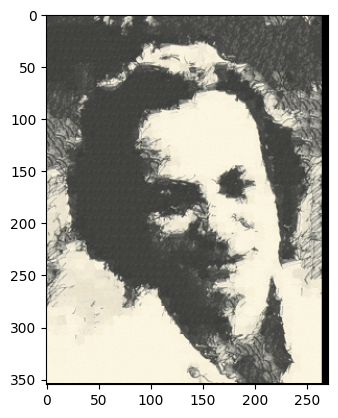

In [82]:
texture_img = cv2.imread('samples/sketch.tiff')
texture_img = cv2.cvtColor(texture_img, cv2.COLOR_BGR2RGB)
guidance_img = cv2.imread('samples/feynman.tiff')
guidance_img = cv2.cvtColor(guidance_img, cv2.COLOR_BGR2RGB)

patch_size = 12#25
overlap = 3#10
tol = 3
alpha = 0.5
num_iters = 3

result_iter = iterative_texture_transfer(texture_img, patch_size, overlap, tol,
                                         guidance_img, alpha,
                                         num_iters=num_iters)

plt.imshow(result_iter)
plt.show()


(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

In [107]:
# debug version
def choose_sample(cost, tol):
    # pick a patch spot based on cost, handle weird cases

    flat_cost = cost.flatten()

    valid_indices = np.where(np.isfinite(flat_cost))[0]  # to skip NaNs/infs
    if len(valid_indices) == 0:
        raise ValueError("no valid patches to pick.")

    sorted_indices = valid_indices[np.argsort(flat_cost[valid_indices])]
    max_idx = min(int(tol * len(sorted_indices)), len(sorted_indices) - 1)
    if max_idx < 0:
        raise ValueError("tol too high or no patches.")

    rando_idx = sorted_indices[random.randint(0, max_idx)]
    return rando_idx // cost.shape[1], rando_idx % cost.shape[1]

#--------------------------------------
# [pipeline]
#   create_face_in_toast
#     1. texture_transfer
#     2. create_feathered_mask          - used in laplacian_pyramid_blending (3)
#     3. laplacian_pyramid_blending
#       i. build_gaussian_pyramid
#       ii. build_laplacian_pyramid
#       iii. reconstruct_from_laplacian - rebuild blended final image
#--------------------------------------

# 1. Gaussian Pyramid
def build_gaussian_pyramid(im, max_levels):
    pyramid = [im.astype(np.float32)]
    for _ in range(max_levels - 1):
        im = cv2.pyrDown(im)
        pyramid.append(im.astype(np.float32))
    return pyramid

# 2. Laplacian Pyramid
# builds from the Gaussian pyramid built
def build_laplacian_pyramid(gaussian_pyramid):
    laplacian_pyramid = []
    for i in range(len(gaussian_pyramid) - 1):
        size = (gaussian_pyramid[i].shape[1], gaussian_pyramid[i].shape[0])
        upsampled = cv2.pyrUp(gaussian_pyramid[i + 1], dstsize=size)
        laplacian = gaussian_pyramid[i] - upsampled
        laplacian_pyramid.append(laplacian)
    laplacian_pyramid.append(gaussian_pyramid[-1])
    return laplacian_pyramid

# (helper function) for rebuidliing from Laplacian pyramid
# that is, edges -> full image
def reconstruct_from_laplacian(laplacian_pyramid):
    im = laplacian_pyramid[-1]
    for i in range(len(laplacian_pyramid) - 2, -1, -1):
        size = (laplacian_pyramid[i].shape[1], laplacian_pyramid[i].shape[0])
        im = cv2.pyrUp(im, dstsize=size) + laplacian_pyramid[i]
    return im

#  3. blends the toast texture (expressed as a face patch) with the original toast image
def laplacian_pyramid_blending(image_A, image_B, mask, max_levels):
    mask_blur = build_gaussian_pyramid(mask, max_levels)
    blur_A = build_gaussian_pyramid(image_A, max_levels)
    edges_A = build_laplacian_pyramid(blur_A)
    blur_B = build_gaussian_pyramid(image_B, max_levels)
    edges_B = build_laplacian_pyramid(blur_B)

    blended_edges = []
    for i in range(max_levels):
        mask_level = mask_blur[i][..., np.newaxis] if len(mask_blur[i].shape) == 2 else mask_blur[i]
        blended_level = mask_level * edges_B[i] + (1 - mask_level) * edges_A[i]
        blended_edges.append(blended_level)

    blended_img = reconstruct_from_laplacian(blended_edges)
    return np.clip(blended_img, 0, 255).astype(np.uint8)

# 4. make a soft mask for blending
# fade edges for smooth toast-face mix
def create_feathered_mask(shape, x1, y1, x2, y2):
    mask = np.zeros(shape, dtype=np.float32)
    mask[y1:y2, x1:x2] = 1
    mask_bin = (mask * 255).astype(np.uint8)
    dist = cv2.distanceTransform(mask_bin, cv2.DIST_L2, 3)
    max_dist = np.max(dist)
    feathered_mask = dist / max_dist
    return feathered_mask

def create_face_in_toast(toast_path, face_path):
    toast_im = cv2.imread(toast_path)
    face_im = cv2.imread(face_path)

    if toast_im is None or face_im is None:
        raise ValueError("can’t load one or both pics.")
    if toast_im.shape[0] < 20 or toast_im.shape[1] < 20:
        raise ValueError("toast pic too small for 20x20 patches.")

    # hard coded toast spot
    x1, y1 = 63, 41
    x2, y2 = 241, 198

    # 0. resize the face to fit toast spot
    #   e.g., resize 178x157 face to match
    face_resized = cv2.resize(face_im, (x2 - x1, y2 - y1))

    # 1. texture transfer (toast -> face)
    try:
        swapped_patch = texture_transfer(
            sample=toast_im,
            patch_size=7,
            overlap=3,
            tol=0.1,
            guide_img=face_resized,
            alpha=0.7
        )
    except ValueError as e:
        print(f"texture swap failed: {e}")
        return None

    base = toast_im.copy()
    blend = toast_im.copy()
    blend[y1:y2, x1:x2] = swapped_patch

    # 2. make 'soft' mask for smooth edges
    mask = create_feathered_mask(toast_im.shape[:2], x1, y1, x2, y2)

    # 3. blend toast and face (with pyramid)
    face_in_toast_im = laplacian_pyramid_blending(base, blend, mask, max_levels=8)

    cv2.imwrite('face_in_toast.png', face_in_toast_im)
    return face_in_toast_im

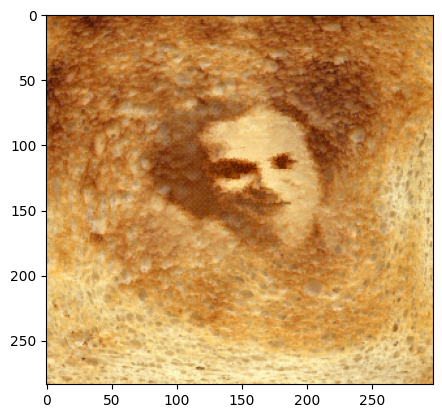

In [108]:
toast_path = 'samples/toast.png'
face_path = 'samples/feynman.tiff'
final_toast_face = create_face_in_toast(toast_path, face_path)

if final_toast_face is not None:
    plt.imshow(cv2.cvtColor(final_toast_face, cv2.COLOR_BGR2RGB))
    plt.show()

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).

In [112]:
"""
  fill toast holes from outside in, prioritizing edges
  use solidity (known/9x9 patch) and edge strength (max gradient)
  mix scores to pick spots, grab best 9x3 patch within ±50, blend it

  loop till holes gone
"""
# 1. CONFIDENCE (ratio of known pixels around the neighborhood)
# count known bits in a patch for holes
def compute_confidence(mask, patch_size):
    # known pixels = 1 / holes = 0
    confidence = np.ones_like(mask, dtype=float)
    confidence[mask == 0] = 0

    half_patch = patch_size // 2
    padded_mask = np.pad(mask, half_patch, mode='constant', constant_values=1)
    confidence_ratio = np.zeros_like(mask, dtype=float)

    m_r, m_c = mask.shape
    for y in range(m_r):
        for x in range(m_c):
            # if hole
            if mask[y, x] == 0:
                patch = padded_mask[y:y + patch_size, x:x + patch_size]
                confidence_ratio[y, x] = np.sum(patch) / (patch_size ** 2)

    return confidence_ratio

# spot strong edges to guide hole fixing in toast.
def compute_edge_strength(image, hole_mask, patch_size):

    # to grayscale if colorful
    if len(image.shape) == 3:
        gray_toast = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_toast = image

    # i. edge strength
    # (used Sobel for gradient computation)
    left_right_change = cv2.Sobel(gray_toast, cv2.CV_64F, 1, 0, ksize=3)
    up_down_change = cv2.Sobel(gray_toast, cv2.CV_64F, 0, 1, ksize=3)
    edge_power = np.sqrt(left_right_change ** 2 + up_down_change ** 2)

    # ii. scale edge strength to 0~1
    scaled_edge_power = edge_power / (np.max(edge_power) + 1e-6)

    # iii. make blank edge map for holes, same size as toast mask
    edge_map_for_holes = np.zeros_like(hole_mask, dtype=float)
    patch_half = patch_size // 2
    padded_edge_power = np.pad(scaled_edge_power, patch_half, mode='constant', constant_values=0)

    # scan each hole spot for strongest edge
    # e.g., check 3x3 patch at holes in 5x5
    for row in range(hole_mask.shape[0]):
        for col in range(hole_mask.shape[1]):
            if hole_mask[row, col] == 0:  # check hole spots
                edge_patch = padded_edge_power[row:row + patch_size, col:col + patch_size]
                edge_map_for_holes[row, col] = np.max(edge_patch)  # pick strongest edge
    return edge_map_for_holes

# Find hole edges  <----
# spot where holes meet toast
def get_frontier(mask):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilated = cv2.dilate(mask, kernel, iterations=1)
    frontier = dilated - mask
    return frontier

# Hunt for the best patch match
# search nearby for a patch to fill holes
def find_best_patch(image, target_patch, target_mask, patch_size, search_area):
    h, w = image.shape[:2]
    half_patch = patch_size // 2
    best_ssd = float('inf')
    best_patch = None

    y_min, y_max, x_min, x_max = search_area
    y_min = max(0, y_min - half_patch)
    y_max = min(h - patch_size, y_max + half_patch)
    x_min = max(0, x_min - half_patch)
    x_max = min(w - patch_size, x_max + half_patch)

    for y in range(y_min, y_max):
        for x in range(x_min, x_max):
            candidate = image[y:y + patch_size, x:x + patch_size]
            candidate_mask = mask[y:y + patch_size, x:x + patch_size]  # assuming 'mask' is defined

            # skip if patch has holes
            if np.any(candidate_mask == 0):
                continue

            # calc SSD on solid bits
            diff = target_patch - candidate
            valid_mask = target_mask == 1  # e.g., 3x3 solid in 5x5
            if np.sum(valid_mask) == 0:
                continue

            # fix SSD shape for colors
            valid_mask_expanded = np.expand_dims(valid_mask, axis=2)  # e.g., 3x3x1
            ssd = np.sum((diff ** 2) * valid_mask_expanded) / np.sum(valid_mask)

            if ssd < best_ssd:
                best_ssd = ssd
                best_patch = candidate.copy()
    return best_patch, best_ssd

# Stick patch into image
# slap patch onto toast, overwrite holes
def blend_patch(image, patch, y_start, x_start, patch_mask):
    patch_h, patch_w = patch.shape[:2]
    region = image[y_start:y_start + patch_h, x_start:x_start + patch_w]
    region[patch_mask == 0] = patch[patch_mask == 0]  # fill holes
    image[y_start:y_start + patch_h, x_start:x_start + patch_w] = region

# Fill toast holes smartly
# patch up toast gaps with priority picks
def fill_hole(image, mask, patch_size=9):
    working_image = image.copy()
    working_mask = mask.copy()  # holes = 0, toast = 1

    # score patch solidity and edges
    # e.g., 9x9 patches on 256x256 toast
    confidence = compute_confidence(working_mask, patch_size)
    edge_strength = compute_edge_strength(working_image, working_mask, patch_size)

    while np.any(working_mask == 0):
        # find hole edges
        # e.g., edges in 256x256 toast hole
        frontier = get_frontier(working_mask)
        if np.sum(frontier) == 0:  # no edges left
            break

        # rank spots by solidity and edges
        priority = confidence * edge_strength
        priority[frontier == 0] = -1  # ignore non-edges

        # pick top spot to fix
        # e.g., (128,73) in 256x256 toast
        y, x = np.unravel_index(np.argmax(priority), priority.shape)

        # set patch area, stay in bounds
        # e.g., 9x9 around (128,73) in 256x256
        half_patch = patch_size // 2
        patch_y_start = max(y - half_patch, 0)
        patch_y_end = min(y + half_patch + 1, working_image.shape[0])
        patch_x_start = max(x - half_patch, 0)
        patch_x_end = min(x + half_patch + 1, working_image.shape[1])

        patch_h = patch_y_end - patch_y_start
        patch_w = patch_x_end - patch_x_start

        target_patch = working_image[patch_y_start:patch_y_end, patch_x_start:patch_x_end]
        target_mask = working_mask[patch_y_start:patch_y_end, patch_x_start:patch_x_end]

        # search area for patch match
        # e.g., ±50 around (128,73) in 256x256
        search_area = (max(0, y - 50), min(working_image.shape[0], y + 50),
                       max(0, x - 50), min(working_image.shape[1], x + 50))

        # find best patch nearby
        # e.g., 9x9 match in 256x256 toast
        best_patch, best_ssd = find_best_patch(working_image, target_patch, target_mask, patch_h, search_area)

        if best_patch is None:
            continue  # skip if no match

        # slap patch onto toast
        # e.g., fill 9x9 hole at (128,73)
        blend_patch(working_image, best_patch, patch_y_start, patch_x_start, target_mask)

        # update hole map and scores
        # e.g., mark 9x9 as solid, recompute edges
        working_mask[patch_y_start:patch_y_end, patch_x_start:patch_x_end][target_mask == 0] = 1
        confidence[patch_y_start:patch_y_end, patch_x_start:patch_x_end] = 1.0
        edge_strength = compute_edge_strength(working_image, working_mask, patch_size)

    return working_image

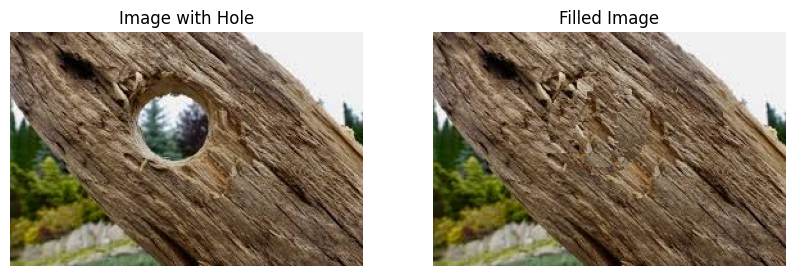

True

In [113]:
# Load the image
image = cv2.imread('samples/hole.jfif')
if image is None:
    print("Error: Could not load image.")
    exit()

# Create a synthetic arbitrary-shaped hole for demonstration
h, w = image.shape[:2]
mask = np.ones((h, w), dtype=np.uint8)
# Simulate an irregular hole centered at (h//2, w//2), ~50x50 pixels
cv2.circle(mask, (128, 73), 39, 0, -1)  # Circular base
# cv2.rectangle(mask, (w//2 - 20, h//2 - 30), (w//2 + 30, h//2 + 20), 0, -1)  # Overlap with rectangle

# Fill the hole
patch_size = 10
filled_image = fill_hole(image, mask, patch_size=patch_size)

# Display results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#plt.imshow(cv2.cvtColor(image * mask[..., np.newaxis], cv2.COLOR_BGR2RGB))
plt.title("Image with Hole")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(filled_image, cv2.COLOR_BGR2RGB))
plt.title("Filled Image")
plt.axis('off')

plt.show()

# Save the result
cv2.imwrite('filled_toast.png', filled_image)